In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import itertools
import time
from sklearn.metrics import roc_auc_score, r2_score
from collections import Counter
import regex as re
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import path
import shap
import scipy
import mrmr
from scipy.stats import pearsonr
from scipy import stats
from sklearn import tree
from matplotlib.figure import Figure
import copy

In [2]:
csv_path = os.getcwd()
csv_path

'/Users/saurabh/Desktop/HeartProjects/Exhalted/Params/Code_EXH/unexplained_dyspnea'

In [4]:
# reading shape features file
important_features_shape_df = pd.read_csv('vol_pyrads_3d_fractals_2d.csv')
important_features_shape_df.drop(columns=['Unnamed: 0', 'dyspnea'],inplace=True)
important_features_shape_df.head()

,patient_id,ed_val_original_shape_MinorAxisLength,std_dev_original_shape_VoxelVolume,min_original_shape_SurfaceVolumeRatio,ed_val_original_shape_MeshVolume,mean_original_shape_Maximum2DDiameterRow,mean_original_shape_MajorAxisLength,mean_original_shape_Sphericity,max_original_shape_Maximum3DDiameter,min_original_shape_MajorAxisLength,...,lv_std_std_distance_ratio_x,lv_std_average_radial_ratio_x,lv_avg_std_distance_ratio_y,lv_avg_average_radial_ratio_y,lv_std_compactness_y,lvmc_avg_average_radial_ratio_y,lvmc_avg_smoothness_y,lv_std_std_distance_ratio_y,lv_std_average_radial_ratio_y,pkvo2
0,101B,49.740365,30097.474262,0.129696,131872.171875,82.797960,74.694549,0.656805,93.939143,66.251094,...,0.021420,0.033201,0.072192,0.866036,0.833340,0.887405,15.200941,0.013599,0.033473,1.52
1,103,61.196740,33476.877838,0.106657,201691.828125,98.243603,89.957593,0.743902,109.454400,86.169647,...,0.021518,0.033120,0.082624,0.838511,0.242789,0.938356,19.741974,0.041558,0.057375,2.36
2,105B,59.891196,33533.562515,0.105672,224877.617188,102.779518,94.498109,0.744217,109.117268,84.664772,...,0.015523,0.022261,0.050001,0.892210,0.339924,0.919576,19.823505,0.011419,0.021140,2.53
3,109,54.112955,41850.236628,0.124354,151871.007812,87.421812,79.522228,0.720003,103.601777,61.725231,...,0.021907,0.029107,0.088542,0.840034,0.898496,0.901940,16.606575,0.020674,0.033041,1.23
4,113B,47.723800,30486.301783,0.150528,107138.031250,91.277966,83.795321,0.644375,101.927670,77.215350,...,0.027851,0.069127,0.085987,0.831353,1.464580,0.889883,13.102552,0.022662,0.045689,1.32


In [5]:
# filtering out fractal features
fractal_slope_features = [feat for feat in important_features_shape_df.columns.values if 'slope' in feat]
fractal_slope_features

['lv_es_slope', 'lv_min_slope', 'lvmc_min_slope']

In [6]:
# filtering out fractal features
fractal_intercept_features = [feat for feat in important_features_shape_df.columns.values if 'intercept' in feat]
fractal_intercept_features

[]

In [7]:
# dropping fractal features since they depend on resolution
important_features_shape_df.drop(columns=fractal_slope_features,inplace=True)

In [8]:
# extracting numerical columns for scaling
numerical_columns = list(important_features_shape_df.columns.values)
numerical_columns.remove('patient_id')
numerical_columns.remove('pkvo2')

In [9]:
# scaling numerical columns
important_features_shape_df_scaled = important_features_shape_df.copy(deep=True)
important_features_shape_df_scaled[numerical_columns] = scaler.fit_transform(important_features_shape_df[numerical_columns])
important_features_shape_df_scaled.reset_index(inplace=True, drop=True)
important_features_shape_df_scaled.head()

,patient_id,ed_val_original_shape_MinorAxisLength,std_dev_original_shape_VoxelVolume,min_original_shape_SurfaceVolumeRatio,ed_val_original_shape_MeshVolume,mean_original_shape_Maximum2DDiameterRow,mean_original_shape_MajorAxisLength,mean_original_shape_Sphericity,max_original_shape_Maximum3DDiameter,min_original_shape_MajorAxisLength,...,lv_std_std_distance_ratio_x,lv_std_average_radial_ratio_x,lv_avg_std_distance_ratio_y,lv_avg_average_radial_ratio_y,lv_std_compactness_y,lvmc_avg_average_radial_ratio_y,lvmc_avg_smoothness_y,lv_std_std_distance_ratio_y,lv_std_average_radial_ratio_y,pkvo2
0,101B,0.355539,0.400857,0.514897,0.333549,0.194511,0.227005,0.088075,0.224911,0.289419,...,0.236749,0.323871,0.335855,0.729831,0.292527,0.285515,0.260691,0.148022,0.240439,1.52
1,103,0.910598,0.484129,0.021096,0.783051,0.577342,0.584185,0.705236,0.555939,0.692156,...,0.238265,0.322619,0.493740,0.445717,0.000000,1.000000,0.623471,0.603243,0.549118,2.36
2,105B,0.847345,0.485526,0.000000,0.932322,0.689767,0.690441,0.707463,0.548746,0.661729,...,0.145246,0.156339,0.000000,1.000000,0.048116,0.736656,0.629984,0.112519,0.081175,2.53
3,109,0.567390,0.690459,0.400400,0.462303,0.309116,0.339980,0.535893,0.431070,0.197910,...,0.244308,0.261172,0.583313,0.461431,0.324802,0.489351,0.372986,0.263205,0.234864,1.23
4,113B,0.257837,0.410438,0.961390,0.174310,0.404694,0.439978,0.000000,0.395352,0.511108,...,0.336520,0.873987,0.544636,0.371828,0.605209,0.320269,0.093052,0.295584,0.398202,1.32


In [11]:
# reading texture features csv file
important_features_texture_df = pd.read_csv('important_texture_3d_features.csv')
important_features_texture_df.drop(columns=['Unnamed: 0', 'pkvo2'],inplace=True)
important_features_texture_df.head()

,median-Laws E3E3S3,median-Laws S3S3L3,median-Gray std_dev ws=3,median-Laws L3S3L3,median-Gradient sobelyz,median-Gradient sobelzx,median-Gradient magnitude,median-Gradient sobelxz,median-Laws L3S3S3,median-Gradient sobelzy,...,"skewness-Gabor XY-θ=1.178, XZ-θ=1.571, λ=0.880, BW=1","skewness-Gabor XY-θ=1.571, XZ-θ=1.571, λ=0.880, BW=1","skewness-Gabor XY-θ=1.963, XZ-θ=1.571, λ=0.880, BW=1","skewness-Gabor XY-θ=2.356, XZ-θ=1.571, λ=0.880, BW=1","skewness-Gabor XY-θ=2.749, XZ-θ=1.571, λ=0.880, BW=1","skewness-Gabor XY-θ=1.571, XZ-θ=0.785, λ=0.880, BW=1","skewness-Gabor XY-θ=0.000, XZ-θ=2.356, λ=0.880, BW=1","skewness-Gabor XY-θ=0.000, XZ-θ=0.785, λ=0.880, BW=1",skewness-Laws S3S3S3,patient_id
0,0.0,3.0,32.966292,1018.0,-75.0,24.0,31.721444,143.0,6.0,-59.0,...,0.132500,0.132500,0.132500,0.132500,0.132500,0.173203,0.184406,0.191166,0.351876,101B
1,-1.0,10.0,25.971547,388.0,-271.0,351.0,24.929902,221.0,10.0,-332.0,...,-0.231362,-0.231362,-0.231362,-0.231362,-0.231362,-0.060460,-0.087546,-0.052435,0.248318,103
2,0.0,6.0,17.474517,309.5,-9.0,59.5,16.120601,-7.5,3.0,-50.0,...,-0.762869,-0.762869,-0.762869,-0.762869,-0.762869,-0.648606,-0.652213,-0.653317,0.579568,105B
3,0.0,32.0,36.861138,790.0,-459.0,383.0,37.569935,410.0,15.0,-469.0,...,0.088654,0.088654,0.088654,0.088654,0.088654,0.208908,0.209827,0.239826,0.097266,109
4,0.0,27.0,56.758966,1851.0,-757.0,822.0,37.218947,450.0,5.0,-618.0,...,0.275969,0.275969,0.275969,0.275969,0.275969,0.441740,0.531490,0.360195,0.464840,113B


In [12]:
# extracting numerical columns for scaling
numerical_columns = list(important_features_texture_df.columns.values)
numerical_columns.remove('patient_id')

In [13]:
# scaling numerical features
important_features_texture_df_scaled = important_features_texture_df.copy(deep=True)
important_features_texture_df_scaled[numerical_columns] = scaler.fit_transform(important_features_texture_df[numerical_columns])
important_features_texture_df_scaled.reset_index(inplace=True, drop=True)
important_features_texture_df_scaled.head()

,median-Laws E3E3S3,median-Laws S3S3L3,median-Gray std_dev ws=3,median-Laws L3S3L3,median-Gradient sobelyz,median-Gradient sobelzx,median-Gradient magnitude,median-Gradient sobelxz,median-Laws L3S3S3,median-Gradient sobelzy,...,"skewness-Gabor XY-θ=1.178, XZ-θ=1.571, λ=0.880, BW=1","skewness-Gabor XY-θ=1.571, XZ-θ=1.571, λ=0.880, BW=1","skewness-Gabor XY-θ=1.963, XZ-θ=1.571, λ=0.880, BW=1","skewness-Gabor XY-θ=2.356, XZ-θ=1.571, λ=0.880, BW=1","skewness-Gabor XY-θ=2.749, XZ-θ=1.571, λ=0.880, BW=1","skewness-Gabor XY-θ=1.571, XZ-θ=0.785, λ=0.880, BW=1","skewness-Gabor XY-θ=0.000, XZ-θ=2.356, λ=0.880, BW=1","skewness-Gabor XY-θ=0.000, XZ-θ=0.785, λ=0.880, BW=1",skewness-Laws S3S3S3,patient_id
0,0.5,0.09375,0.404194,0.496677,0.841738,0.042872,0.524470,0.328225,0.171429,0.930055,...,0.629034,0.629034,0.629034,0.629034,0.629034,0.622604,0.583126,0.568597,0.839285,101B
1,0.0,0.31250,0.229035,0.116012,0.631438,0.393355,0.300478,0.427842,0.285714,0.631694,...,0.373406,0.373406,0.373406,0.373406,0.373406,0.445580,0.393574,0.404579,0.766190,103
2,0.5,0.18750,0.016256,0.068580,0.912554,0.080922,0.009937,0.136015,0.085714,0.939891,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,105B
3,0.5,1.00000,0.501727,0.358912,0.429721,0.427653,0.717359,0.669221,0.428571,0.481967,...,0.598230,0.598230,0.598230,0.598230,0.598230,0.649654,0.600844,0.601361,0.659570,109
4,0.5,0.84375,1.000000,1.000000,0.109979,0.898178,0.705783,0.720307,0.142857,0.319126,...,0.729827,0.729827,0.729827,0.729827,0.729827,0.826047,0.825044,0.682406,0.919020,113B


In [14]:
# reading csv file with clinical features
important_features_clinical_df = pd.read_csv('important_clinical_features.csv')
important_features_clinical_df.drop(columns=['Unnamed: 0'],inplace=True)
important_features_clinical_df.head()

,Systolic blood pressure,Diastolic blood pressure,Age,Number of Inhlaers,Number of hypertension medications,White Blood Cell Count,Red Blood Cell Count,Hemoglobin,Hematocrit,MCV,...,Absolute Neutrophils,Absolute Lymphocytes,Absolute Monocytes,Absolute Eosinophils,Absolute Basophils,Age:,Height (cm):,Weight (kg):,BMI,patient_id
0,132.0,92.0,60.0,0.0,0.0,4.3,5.05,15.0,44.3,88.0,...,1.95,1.77,0.43,0.13,0.02,60.0,170.0,75.3,26.055363,101B
1,127.0,73.0,44.0,0.0,0.0,3.3,5.45,16.1,49.6,91.0,...,1.58,11.23,0.36,0.14,0.01,44.0,173.0,142.7,47.679508,103
2,120.0,72.0,53.0,2.0,0.0,4.4,4.19,13.8,40.3,96.0,...,2.34,1.47,0.36,0.23,0.03,53.0,188.0,116.6,32.990041,105B
3,122.0,64.0,52.0,2.0,0.0,13.3,3.97,12.4,37.7,95.0,...,10.95,1.82,0.38,0.01,0.04,52.0,164.0,137.7,51.197204,109
4,120.0,80.0,61.0,0.0,0.0,4.2,5.04,14.5,42.8,85.0,...,2.53,1.03,0.42,0.11,0.06,61.0,155.0,70.7,29.427680,113B


In [15]:
# dropping unwanted columns
important_features_clinical_df.drop(columns=['Number of hypertension medications', 'Number of Inhlaers'],inplace=True)

In [16]:
# extracting numerical features for scaling
numerical_columns = list(important_features_clinical_df.columns.values)
numerical_columns.remove('patient_id')

In [17]:
# scaling clinical features
important_features_clinical_df_scaled = important_features_clinical_df.copy(deep=True)
important_features_clinical_df_scaled[numerical_columns] = scaler.fit_transform(important_features_clinical_df[numerical_columns])
important_features_clinical_df_scaled.reset_index(inplace=True, drop=True)
important_features_clinical_df_scaled.head()

,Systolic blood pressure,Diastolic blood pressure,Age,White Blood Cell Count,Red Blood Cell Count,Hemoglobin,Hematocrit,MCV,MCHC,Platelet Count,...,Absolute Neutrophils,Absolute Lymphocytes,Absolute Monocytes,Absolute Eosinophils,Absolute Basophils,Age:,Height (cm):,Weight (kg):,BMI,patient_id
0,0.527778,0.740741,0.818182,0.142857,0.629091,0.689655,0.619910,0.425,0.60,0.227891,...,0.068323,0.099905,0.277108,0.196970,0.250,0.733333,0.404255,0.312245,0.232509,101B
1,0.458333,0.388889,0.575758,0.047619,0.774545,0.879310,0.859729,0.500,0.32,0.105442,...,0.030021,1.000000,0.192771,0.212121,0.125,0.377778,0.468085,1.000000,0.892617,103
2,0.361111,0.370370,0.712121,0.152381,0.316364,0.482759,0.438914,0.625,0.66,0.367347,...,0.108696,0.071361,0.192771,0.348485,0.375,0.577778,0.787234,0.733673,0.444200,105B
3,0.388889,0.222222,0.696970,1.000000,0.236364,0.241379,0.321267,0.600,0.40,0.690476,...,1.000000,0.104662,0.216867,0.015152,0.500,0.555556,0.276596,0.948980,1.000000,109
4,0.361111,0.518519,0.833333,0.133333,0.625455,0.603448,0.552036,0.350,0.60,0.527211,...,0.128364,0.029496,0.265060,0.166667,0.750,0.755556,0.085106,0.265306,0.335454,113B


In [18]:
# combining clinical, shape and texture features
combined_df = pd.merge(important_features_shape_df_scaled, important_features_texture_df_scaled, on="patient_id")
combined_df = pd.merge(combined_df, important_features_clinical_df_scaled, on = 'patient_id')
combined_df.shape

(51, 203)

In [19]:
combined_df.head()

,patient_id,ed_val_original_shape_MinorAxisLength,std_dev_original_shape_VoxelVolume,min_original_shape_SurfaceVolumeRatio,ed_val_original_shape_MeshVolume,mean_original_shape_Maximum2DDiameterRow,mean_original_shape_MajorAxisLength,mean_original_shape_Sphericity,max_original_shape_Maximum3DDiameter,min_original_shape_MajorAxisLength,...,Basophils,Absolute Neutrophils,Absolute Lymphocytes,Absolute Monocytes,Absolute Eosinophils,Absolute Basophils,Age:,Height (cm):,Weight (kg):,BMI
0,101B,0.355539,0.400857,0.514897,0.333549,0.194511,0.227005,0.088075,0.224911,0.289419,...,0.357143,0.068323,0.099905,0.277108,0.196970,0.250,0.733333,0.404255,0.312245,0.232509
1,103,0.910598,0.484129,0.021096,0.783051,0.577342,0.584185,0.705236,0.555939,0.692156,...,0.214286,0.030021,1.000000,0.192771,0.212121,0.125,0.377778,0.468085,1.000000,0.892617
2,105B,0.847345,0.485526,0.000000,0.932322,0.689767,0.690441,0.707463,0.548746,0.661729,...,0.500000,0.108696,0.071361,0.192771,0.348485,0.375,0.577778,0.787234,0.733673,0.444200
3,109,0.567390,0.690459,0.400400,0.462303,0.309116,0.339980,0.535893,0.431070,0.197910,...,0.214286,1.000000,0.104662,0.216867,0.015152,0.500,0.555556,0.276596,0.948980,1.000000
4,113B,0.257837,0.410438,0.961390,0.174310,0.404694,0.439978,0.000000,0.395352,0.511108,...,1.000000,0.128364,0.029496,0.265060,0.166667,0.750,0.755556,0.085106,0.265306,0.335454


In [20]:
# extracting numerical columns
numerical_columns = list(combined_df.columns.values)
numerical_columns.remove('patient_id')
numerical_columns.remove('pkvo2')

In [48]:
# looking at features with high correlation with pkvo2
response = combined_df['pkvo2'] 
numerical_columns = list(set(numerical_columns))
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(combined_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.2];

significant features: 
(feature name, R^2, p-value)

('Height (cm):', 0.447, 0.0)
('lvmc_vol_min', 0.279, 6.8e-05)
('es_val_original_shape_VoxelVolume', 0.263, 0.00012)
('min_original_shape_VoxelVolume', 0.263, 0.00012)
('lv_vol_es', 0.263, 0.00012)
('es_val_original_shape_MeshVolume', 0.262, 0.000122)
('min_original_shape_MeshVolume', 0.262, 0.000122)
('lvmc_vol_ed', 0.251, 0.00018)
('mean_original_shape_VoxelVolume', 0.251, 0.000184)
('median_original_shape_MeshVolume', 0.25, 0.000187)
('mean_original_shape_MeshVolume', 0.25, 0.000185)
('median_original_shape_VoxelVolume', 0.25, 0.000189)
('median_original_shape_SurfaceVolumeRatio', 0.248, 0.000199)
('mean_original_shape_SurfaceVolumeRatio', 0.246, 0.000213)
('min_original_shape_SurfaceArea', 0.241, 0.000255)
('es_val_original_shape_SurfaceArea', 0.238, 0.000286)
('max_original_shape_VoxelVolume', 0.229, 0.000376)
('ed_val_original_shape_VoxelVolume', 0.229, 0.000376)
('ed_val_original_shape_MeshVolume', 0.229, 0.000382)
('max_origin

In [22]:
def adj_r2_score(r2, k):
    '''
    calculates adjusted R2
    '''
    n = 51
    return 1. - ((1.-r2)*(n-1.)/(n-k-1))

In [45]:
def cross_val_5fold(df_scaled, response, hand_selected_features):
    '''
    performs cross validation 100 times and returns the average and standard error of R^2 scores
    '''
    features_subset = hand_selected_features
    X = df_scaled[features_subset]
    y = response
    # Number of random trials
    NUM_TRIALS = 20
    n_splits = 5

    lin_reg = LinearRegression() 
    
    # Arrays to store scores
    val_r2_scores = np.zeros(NUM_TRIALS*n_splits)
    train_r2_scores = np.zeros(NUM_TRIALS*n_splits)
    val_R_scores = np.zeros(NUM_TRIALS*n_splits)
    train_R_scores = np.zeros(NUM_TRIALS*n_splits)
    coeffs = []
    intcepts = []

    for i in range(NUM_TRIALS):
        val_preds_per_trial = []

        cv = KFold(n_splits=n_splits, shuffle=True, random_state=i)

        iteration = 0
        for train_ix, test_ix in cv.split(X,y):
            X_train, X_test = X.loc[train_ix, :], X.loc[test_ix, :]
            y_train, y_test = y[train_ix], y[test_ix]
            
            lin_reg.fit(X_train, y_train)
            y_hat = lin_reg.predict(X_test)
            val_r2_scores[i*n_splits + iteration] = r2_score(y_test, y_hat)    
            train_r2_scores[i*n_splits + iteration] = r2_score(y_train, lin_reg.predict(X_train))            
            val_R_scores[i*n_splits + iteration] = pearsonr(y_test, y_hat)[0]    
            train_R_scores[i*n_splits + iteration] = pearsonr(y_train, lin_reg.predict(X_train))[0]  

            coeffs.append(lin_reg.coef_)
            intcepts.append(lin_reg.intercept_)
            iteration += 1
    sqrt_n = np.sqrt(NUM_TRIALS*n_splits)
    print('validation R^2 scores:', round(val_r2_scores.mean(), 3), round(val_r2_scores.std()/sqrt_n, 2))
    print('training scores:', round(train_r2_scores.mean(), 3), round(train_r2_scores.std()/sqrt_n, 2),'\n')
    
    return val_r2_scores.mean(), val_r2_scores.std()/sqrt_n,\
train_r2_scores.mean(), train_r2_scores.std()/sqrt_n,\
intcepts,coeffs,\
val_R_scores.mean(), val_R_scores.std()/sqrt_n,\
train_R_scores.mean(), train_R_scores.std()/sqrt_n


In [24]:
def interesting_combos_func(df_scaled, numerical_columns, num_feat, shortlisted_features, interesting_combos):
    '''
    scans the feature space to find subsets of interesting features
    '''
    rem_feat = num_feat - len(shortlisted_features)
    rem_columns = list(copy.deepcopy(numerical_columns))
    for feat in shortlisted_features:
        rem_columns.remove(feat) 

    for comb in itertools.combinations(rem_columns, rem_feat):
        important_features_subset = []
        important_features_subset = list(comb)
        important_features_subset.extend(shortlisted_features)
        X = df_scaled[important_features_subset].assign(const=1)
        vif_values = [vif(X.values, i) for i in range(num_feat)]
        if max(vif_values) <= 5.:
            vif_feat_vals = {important_features_subset[ind]: vals for ind,vals in enumerate(vif_values)}
            interesting_combos.append(important_features_subset)
    return interesting_combos

def best_features_subset(df_scaled, response, interesting_combos):
    '''
    returns the best subset of features that has the maximum regression score
    '''
    max_reg = 0.
    multivariate_y = response
    for important_features_subset in interesting_combos:
        multivariate_x = df_scaled[important_features_subset]
        reg = LinearRegression().fit(multivariate_x, multivariate_y)
        reg_score = reg.score(multivariate_x, multivariate_y)
        if reg_score > max_reg:
            max_reg = reg_score
            max_reg_features = important_features_subset
    if interesting_combos == []: return [], 0.

    return max_reg_features, max_reg

In [25]:
def feature_iterations(initial_feature, df, y, numerical_columns, num_iters):
    '''
    iteratively performs cross-validation by increasing the size of the current subset by 1 
    '''
    max_reg_features = initial_feature
    num_feat = len(max_reg_features)
    pkvo2_vals = y

    r2_scores_mean = []
    r2_scores_std = []
    num_feats = []

    for i in range(num_iters):
        num_feat += 1 
        interesting_combos = []
        shortlisted_features =  max_reg_features
        #
        interesting_combos = interesting_combos_func(df, numerical_columns, num_feat, shortlisted_features, interesting_combos)
        print(num_feat, len(interesting_combos))
        #
        max_reg_features, max_reg = best_features_subset(df, pkvo2_vals, interesting_combos)
        if not max_reg_features == []:
            #
            val_r2_scores_mean, val_r2_scores_std,\
            train_r2_scores_mean, train_r2_scores_std,\
            intcepts,coeffs,\
            val_R_scores_mean, val_R_scores_std,\
            train_R_scores_mean, train_R_scores_std = cross_val_5fold(df, pkvo2_vals, max_reg_features)
            r2_scores_mean.append(val_r2_scores_mean)
            r2_scores_std.append(val_r2_scores_std)  
        else:
            r2_scores_mean.append(0.)
            r2_scores_std.append(0.)        
        num_feats.append(num_feat)
    return r2_scores_mean, r2_scores_std, num_feats, max_reg_features, intcepts,coeffs

In [46]:
# iteratively increasing the feature subset by allowing one more feature in each iteration.
# let's start with height since it has the highest correlation with PkVO2
initial_feature = ['Height (cm):']
r2_scores_mean, r2_scores_std, num_feats, max_reg_features, intcepts, coeffs = \
feature_iterations(initial_feature, combined_df, response.values, numerical_columns, 5)

2 200
validation R^2 scores: 0.366 0.03
training scores: 0.533 0.0 

3 199
validation R^2 scores: 0.413 0.03
training scores: 0.602 0.0 

4 195
validation R^2 scores: 0.437 0.03
training scores: 0.655 0.0 

5 193
validation R^2 scores: 0.482 0.03
training scores: 0.698 0.0 

6 192
validation R^2 scores: 0.552 0.03
training scores: 0.741 0.0 



In [27]:
# looking at features with the best R^2 score
max_reg_features

['median-Laws  E3E3S3',
 'kurtosis-Gabor XY-θ=0.785, XZ-θ=0.785, λ=0.880, BW=1',
 'lv_avg_average_radial_ratio_x',
 'median_original_shape_SurfaceVolumeRatio',
 'kurtosis-Laws  E3E3L3',
 'Height (cm):']

In [28]:
# verifying that the features are uncorrelated
X = combined_df[max_reg_features].assign(const=1)
vif_values = [vif(X.values, i) for i in range(len(max_reg_features))]
vif_feat_vals = {max_reg_features[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

Height (cm): 1.577
lv_avg_average_radial_ratio_x 1.3
median_original_shape_SurfaceVolumeRatio 1.298
kurtosis-Gabor XY-θ=0.785, XZ-θ=0.785, λ=0.880, BW=1 1.166
median-Laws  E3E3S3 1.131
kurtosis-Laws  E3E3L3 1.057


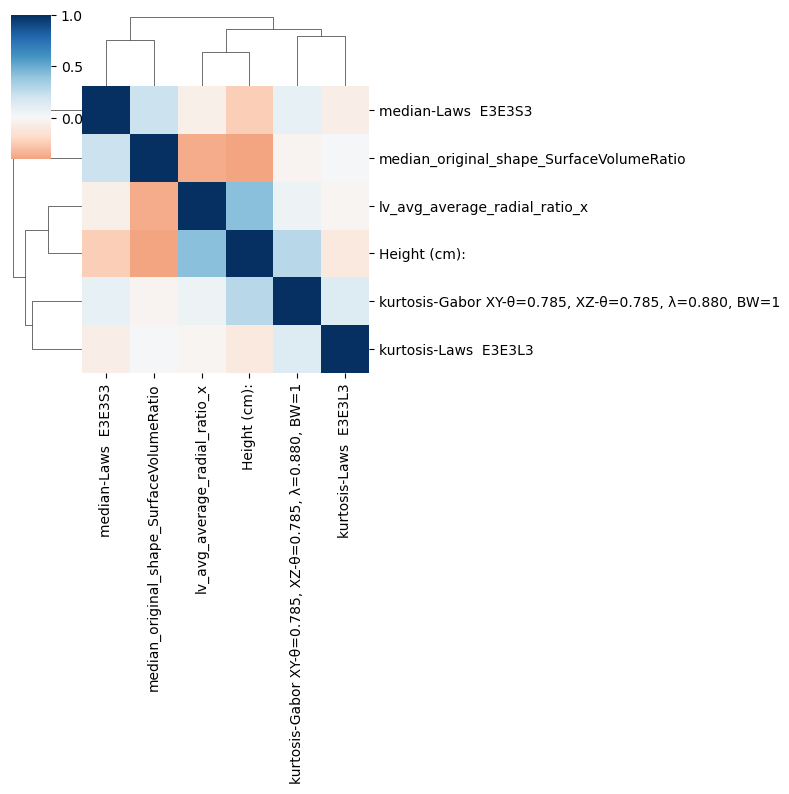

In [56]:
# verifying that the features are uncorrelated
sns.clustermap(combined_df[max_reg_features].corr(),cmap = 'RdBu', center = 0.0, figsize=(8,8));

In [29]:
# calculating mean of coefficients and intercept
mean_coeffs = np.mean(coeffs,axis=0)
mean_intcept = np.mean(intcepts,axis=0)

In [30]:
# looking at the most important features
abs_mean_coeffs = abs(mean_coeffs)
abs_mean_coeffs_args = np.argsort(abs_mean_coeffs)
print('(features, coefficient)')
[(max_reg_features[i], round(mean_coeffs[i],3)) for i in abs_mean_coeffs_args[::-1]]

(features, coefficient)


[('Height (cm):', 1.251),
 ('kurtosis-Laws  E3E3L3', -0.885),
 ('median_original_shape_SurfaceVolumeRatio', -0.86),
 ('median-Laws  E3E3S3', -0.852),
 ('kurtosis-Gabor XY-θ=0.785, XZ-θ=0.785, λ=0.880, BW=1', 0.768),
 ('lv_avg_average_radial_ratio_x', -0.695)]

In [31]:
def confidence_interval(mean_response, ground_truth, X):
    '''
    calculating confidence interval of predictions
    '''
    CI_low_limit = []
    CI_upper_limit = []
    alpha = 0.05
    N = len(mean_response)
    var_n = 5
    X_sq = np.dot(X.T,X)
    X_sq_inv = np.linalg.inv(X_sq)
    mse = sum(np.array(mean_response - ground_truth)**2)/N
    
    for ind, ent in enumerate(mean_response):
        t_multiplier = stats.t.ppf(1.0 - alpha / 2.0, N - (var_n+1))
        std_error = np.sqrt(mse*(np.dot(np.dot(X[ind].T, X_sq_inv), X[ind])))
        low_limit = ent - t_multiplier*std_error
        upper_limit = ent + t_multiplier*std_error
        CI_low_limit.append(low_limit[0])
        CI_upper_limit.append(upper_limit[0])
        
    return CI_low_limit, CI_upper_limit

In [41]:
def average_model_predictions(df, features, y, coeffs, intercepts):
    '''
    returns predictions from average model of 100 iterations
    '''
    mean_coeffs = np.mean(coeffs,axis=0)
    mean_coeffs = np.array(mean_coeffs).reshape((mean_coeffs.shape[0],1))
    mean_intcept = np.mean(intercepts,axis=0)
    X = df[features]
    ans = np.matmul(X, mean_coeffs)
    
    ground_truth = y
    feat_x_X = np.matmul(X, mean_coeffs)
    mean_response = feat_x_X + mean_intcept

    return mean_response.values
    

In [42]:
# making predictions from the average model
ground_truth = response.values
predicted = average_model_predictions(combined_df, max_reg_features, \
                                      ground_truth, coeffs, intcepts)

In [43]:
# calculating R^2 score of average model
print('R^2 score =', round(r2_score(ground_truth, predicted),2))

R^2 score = 0.73


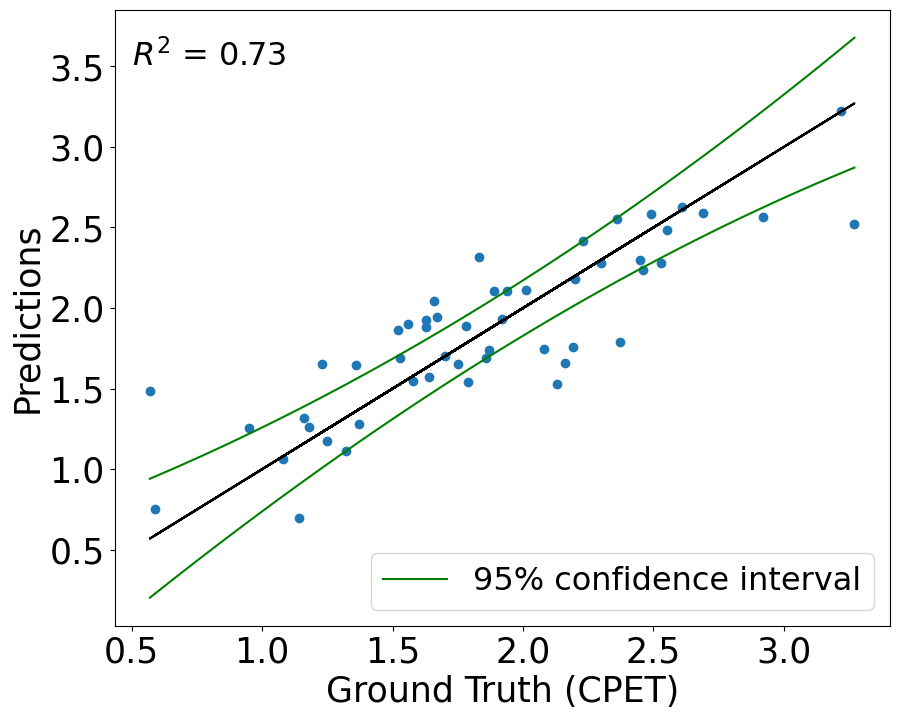

In [44]:
# One-on-one plot between predictions vs ground truth
fontsize=25
spl_low = UnivariateSpline(sorted(predicted), sorted(CI_low_limit))
spl_upper = UnivariateSpline(sorted(predicted), sorted(CI_upper_limit))
xs = np.linspace(min(ground_truth), max(ground_truth), 100)
plt.figure(figsize=(10,8))
plt.scatter(ground_truth, predicted)
plt.plot(ground_truth, ground_truth, c='black')
plt.plot(xs, spl_low(xs),c='green',label='95% confidence interval')
plt.plot(xs, spl_upper(xs), c='green')
plt.xlabel('Ground Truth (CPET)', fontsize=fontsize)
plt.ylabel('Predictions', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.text(0.5,3.5,f'$R^2$ = {round(r2_score(ground_truth, [ent[0] for ent in predicted]),2)}',fontsize=fontsize-2)
plt.legend(loc='lower right',fontsize=fontsize-2)
plt.savefig('scatter_plot_combined.png')
plt.show()